Mount Drive


In [47]:
from google.colab import drive
import pandas as pd
import numpy as np
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Imports

In [48]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
import seaborn as sns
import sklearn
import sklearn.metrics as metrics
from keras.backend import clear_session
from keras.layers import Dense
from keras.models import Sequential
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import joblib
from sklearn.neural_network import MLPRegressor

Read Data

In [49]:
def scale_datasets(df):
  scaled_cols = []
  for col in df.columns.drop('total_points'):
    if df[col].nunique() > 2:
      scaled_cols.append(col)
  std_pred, std_resp = StandardScaler(), StandardScaler()
  X_train, y_train = df.drop('total_points', axis=1), df['total_points'] 
  X_train[scaled_cols] = pd.DataFrame(std_pred.fit_transform(X_train[scaled_cols]), 
                                      columns=df[scaled_cols].columns,
                                      index=X_train.index)
  y_train = pd.DataFrame(std_resp.fit_transform(y_train.to_numpy().reshape(-1, 1)),
                                                columns=['total_points'], index=y_train.index)
  return X_train, y_train, std_resp

def dont_scale_datasets(df):
  X_train, y_train = df.drop('total_points', axis=1), df['total_points'] 
  return X_train, y_train

def preprocess_data(df):
  # Drop indexing features
  idxrs = df[['player_name', 'kickoff_time', 'season', 'GW']]
  df = df.drop(columns = ['player_name', 'kickoff_time', 'season', 'GW'])
  # Binary encoding
  for col in df.columns:
    df[col] = df[col].replace({True:1, False:0})
  # One hot encodings
  ohe_cols = []
  for col in df.select_dtypes(include='object').columns:
      ohe_cols.append(col)
  df = pd.get_dummies(df, columns=ohe_cols, prefix=ohe_cols)
  df['kickoff_time'] = idxrs['kickoff_time']
  df['GW'] = idxrs['GW']
  return df


def get_training_data(GW, scale):
    df = pd.read_csv('./drive/MyDrive/Data/engineered_us.csv')
    df.drop(['team', 'opponent_team'], inplace = True, axis = 1)
    df = preprocess_data(df)
    min_date = df[(df['GW'] == GW) & (df['kickoff_time'] >= '2020-08-12')]['kickoff_time'].min() # The first date of the gameweek
    max_date = df[(df['GW'] == GW) & (df['kickoff_time'] > '2020-08-12')]['kickoff_time'].max() # The last date of the gameweek
    df_scl = df[df['kickoff_time'] <= max_date].copy() # Only includes up to gameweek 
    std_x, std_y = StandardScaler(), StandardScaler()
    scaled_cols = []
    if scale == True:
      for col in df.columns.drop(['total_points', 'kickoff_time']):
        if df[col].nunique() > 2:
          scaled_cols.append(col)
      df_scl[scaled_cols] = std_x.fit_transform(df_scl[scaled_cols])
      df_scl['total_points'] = std_y.fit_transform(df_scl['total_points'].to_numpy().reshape(-1, 1))
      df_train, df_test = df_scl[df_scl['kickoff_time'] < min_date], df_scl[df_scl['kickoff_time'] >= min_date] 
      X = df_train.drop(['total_points', 'kickoff_time', 'GW'], axis = 1)
      y = df_train['total_points']
      X_val = df_test.drop(['total_points', 'kickoff_time', 'GW'], axis = 1)
      y_val = df_test['total_points']
    else:
      df_train, df_test = df_scl[df_scl['kickoff_time'] < min_date], df_scl[df_scl['kickoff_time'] >= min_date] 
      X = df_train.drop(['total_points', 'kickoff_time', 'GW'], axis = 1)
      y = df_train['total_points']
      X_val = df_test.drop(['total_points', 'kickoff_time', 'GW'], axis = 1)
      y_val = df_test['total_points']
    return X, X_val, y, y_val, std_x, std_y

def write_grid_results(grid, file = 'results.txt'):
  f = open(f'/content/drive/MyDrive/Parameters/{file}', 'w')
  print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
  f.write("Best: %f using %s\n\n" % (grid.best_score_, grid.best_params_))
  means = grid.cv_results_['mean_test_score']
  stds = grid.cv_results_['std_test_score']
  params = grid.cv_results_['params'] 
  used = []
  for mean, stdev, param in zip(means, stds, params):
      print("%f (%f) with: %r" % (mean, stdev, param))
      f.write("%f (%f) with: %r\n\n" % (mean, stdev, param))
      used.append(param)
  f.close()
  


X_train, X_test, y_train, y_test, std_x, std_y = get_training_data(GW = 1, scale = True)

Neural Network Parameter Tuning (~120 min)

---



Coarse Grid Search

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(128, 128), (256, 256), (512,512)],
    'max_iter': [100], # Maximum number of epochs
    'activation': ['relu'], # Activation function for hidden layers
    'solver': ['adam'],
    'alpha': [0, 0.001], #  L2 regularization coefficient
    'learning_rate': ['constant'],
    'batch_size' : [32],
    'power_t':[0.5],
    'learning_rate_init': [0.001], # Value for learning rate
    'momentum':[0.9], # SGD momentum
    'n_iter_no_change':[10], # Convergence for tolerance
    'nesterovs_momentum':[True], # SGD momentum
    'validation_fraction':[0.2], # Size of validation split
    'beta_1': [0.9], # Adam coeff
    'beta_2': [0.999], # Adam coeff
    'epsilon':[1e-07], # As keras
    'tol':[1e-08]
}

net_grid = GridSearchCV(MLPRegressor(verbose = True,  random_state=0, shuffle = True, early_stopping = True), 
                        param_grid, n_jobs= 8, cv=4, verbose = 10).fit(X_train, y_train)
joblib.dump(net_grid, '/content/drive/MyDrive/Parameters/coarse_net_grid.pkl')

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   16.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done  12 out of  24 | elapsed:  2.1min remaining:  2.1min
[Parallel(n_jobs=8)]: Done  15 out of  24 | elapsed:  3.4min remaining:  2.0min
[Parallel(n_jobs=8)]: Done  18 out of  24 | elapsed:  4.3min remaining:  1.4min
[Parallel(n_jobs=8)]: Done  21 out of  24 | elapsed:  5.6min remaining:   48.2s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:  5.9min finished


Iteration 1, loss = 0.46283567
Validation score: 0.083300
Iteration 2, loss = 0.43213520
Validation score: 0.122935
Iteration 3, loss = 0.41612623
Validation score: 0.088830
Iteration 4, loss = 0.40481531
Validation score: 0.109708
Iteration 5, loss = 0.39311951
Validation score: 0.096975
Iteration 6, loss = 0.38375429
Validation score: 0.117076
Iteration 7, loss = 0.36884377
Validation score: 0.041643
Iteration 8, loss = 0.35998928
Validation score: 0.080032
Iteration 9, loss = 0.34635992
Validation score: 0.080331
Iteration 10, loss = 0.32667170
Validation score: 0.052176
Iteration 11, loss = 0.31280642
Validation score: 0.031341
Iteration 12, loss = 0.29484215
Validation score: 0.052294
Iteration 13, loss = 0.28297861
Validation score: -0.018697
Validation score did not improve more than tol=0.000000 for 10 consecutive epochs. Stopping.


['/content/drive/MyDrive/Parameters/coarse_net_grid.pkl']

In [ ]:
net_results = joblib.load('/content/drive/MyDrive/Parameters/coarse_net_grid.pkl')
net_results.best_estimator_

MLPRegressor(activation='relu', alpha=0.001, batch_size=32, beta_1=0.9,
             beta_2=0.999, early_stopping=True, epsilon=1e-07,
             hidden_layer_sizes=(1024, 1024), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=100,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=0, shuffle=True, solver='adam',
             tol=1e-08, validation_fraction=0.2, verbose=True,
             warm_start=False)

Fine Grid Search

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(512,512)], # , (1024,768), (768,1024)
    'max_iter': [100], # Maximum number of epochs
    'activation': ['relu'], # Activation function for hidden layers
    'solver': ['adam'],
    'alpha': [0, 0.001, 0.01, 0.1], #  L2 regularization coefficient
    'learning_rate': ['adaptive'],
    'batch_size' : [32],
    'power_t':[0.5],
    'learning_rate_init': [0.1], # Value for learning rate
    'momentum':[0.9], # SGD momentum
    'n_iter_no_change':[10], # Convergence for tolerance
    'nesterovs_momentum':[True], # SGD momentum
    'validation_fraction':[0.2], # Size of validation split
    'beta_1': [0.9], # Adam coeff
    'beta_2': [0.999], # Adam coeff
    'epsilon':[1e-07], # As keras
    'tol':[1e-08]
}
# verbose = True,  random_state=0, shuffle = True, early_stopping = True
net_grid = GridSearchCV(MLPRegressor(), param_grid, n_jobs=-1, cv=4, verbose = 10).fit(X_train, y_train)
joblib.dump(net_grid, '/content/drive/MyDrive/Parameters/fine_net_grid.pkl')

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 23.3min finished


['/content/drive/MyDrive/Parameters/fine_net_grid.pkl']

Results

In [ ]:
net_results = joblib.load('/content/drive/MyDrive/Parameters/fine_net_grid.pkl')
net_results.best_estimator_

MLPRegressor(activation='relu', alpha=0.001, batch_size=32, beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-07,
             hidden_layer_sizes=(512, 512), learning_rate='adaptive',
             learning_rate_init=0.1, max_fun=15000, max_iter=100, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=1e-08,
             validation_fraction=0.2, verbose=False, warm_start=False)

Compare Random Forest and Catboost

Random Forest Parameter Tuning

---



Coarse Grid Search

In [ ]:
rf_n_estimators = [50, 200, 500, 1000, 3000] # Note lower values do not perform well
rf_max_depth = [5, 10, 50, None]
rf_max_features = ['sqrt']
rf_criterion = ['mse']
rf_min_samples_split = [2, 5, 10, 50]
min_samples_leaf = [1, 10, 20]
               
rf_grid = {'n_estimators': rf_n_estimators,
               'max_depth': rf_max_depth,
               'max_features': rf_max_features,
               'criterion': rf_criterion,
               'min_samples_split': rf_min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rf_base = RandomForestRegressor()
rf_grid = GridSearchCV(estimator = rf_base, param_grid = rf_grid, cv = 4, verbose = 10, n_jobs = 8)
rf_grid.fit(X_train, y_train)
joblib.dump(rf_grid, '/content/drive/MyDrive/Parameters/coarse_random_forest_grid.pkl')

Fitting 4 folds for each of 240 candidates, totalling 960 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:   26.7s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   59.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:  3.1min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  4.3min
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:  5.5min
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:  6.1min
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:  7.7min
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:  8.9min
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed: 10.4min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 11.5min
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed: 13.1min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 14.5min
[Parallel(

['/content/drive/MyDrive/Parameters/coarse_random_forest_grid.pkl']

In [11]:
rf_results = joblib.load('/content/drive/MyDrive/Parameters/coarse_random_forest_grid.pkl')
rf_results.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Fine Grid Search

In [ ]:
rf_n_estimators = [2000]
rf_max_depth = [40, 50, 60]
rf_max_features = ['auto']
rf_criterion = ['mse']
rf_min_samples_split = [2]
min_samples_leaf = [1, 3]
               
rf_grid = {'n_estimators': rf_n_estimators,
               'max_depth': rf_max_depth,
               'max_features': rf_max_features,
               'criterion': rf_criterion,
               'min_samples_split': rf_min_samples_split}
rf_base = RandomForestRegressor()
rf_grid = GridSearchCV(estimator = rf_base, param_grid = rf_grid, 
                              cv = 3, verbose = 10, n_jobs = 8)
rf_grid.fit(X_train, y_train)
joblib.dump(rf_grid, '/content/drive/MyDrive/Parameters/fine_random_forest_grid.pkl')

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  3.1min
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:  8.4min
[Parallel(n_jobs=8)]: Done  15 out of  27 | elapsed: 13.2min remaining: 10.5min
[Parallel(n_jobs=8)]: Done  18 out of  27 | elapsed: 13.7min remaining:  6.8min
[Parallel(n_jobs=8)]: Done  21 out of  27 | elapsed: 14.4min remaining:  4.1min
[Parallel(n_jobs=8)]: Done  24 out of  27 | elapsed: 17.6min remaining:  2.2min
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed: 17.9min remaining:    0.0s
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed: 17.9min finished


['/content/drive/MyDrive/Parameters/fine_random_forest_grid.pkl']

Results

In [ ]:
rf_results = joblib.load('/content/drive/MyDrive/Parameters/fine_random_forest_grid.pkl')
rf_results.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Support Vector Regression Parameter Tuning (~10 hours)

---



Coarse Grid Search (RBF)

In [ ]:
# Reduced grid size
param_grid = {'C': [1, 10, 100], 
              'gamma': [1, 0.1, 0.001], 
              'epsilon' : [0.01, 0], 
              'kernel': ['rbf']}
svr_grid = GridSearchCV(SVR(), param_grid, n_jobs= 8, cv = 4,verbose = 10).fit(X_train, y_train)
joblib.dump(svr_grid, '/content/drive/MyDrive/Parameters/coarse_svr_grid_quad.pkl')

Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  6.1min
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  7.5min
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed: 10.7min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 15.1min
[Parallel(n_jobs=8)]: Done  65 out of  72 | elapsed: 18.9min remaining:  2.0min
[Parallel(n_jobs=8)]: Done  72 out of  72 | elapsed: 19.5min finished


['/content/drive/MyDrive/Parameters/coarse_svr_grid_quad.pkl']

In [ ]:
svr_grid.best_estimator_

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Coarse Grid Search (Poly)

In [ ]:
# Reduced grid size
param_grid = {'C': [1, 10, 100], 
              'degree': [2, 4, 6], 
              'epsilon' : [0.01, 0], 
              'kernel': ['poly']}
svr_grid = GridSearchCV(SVR(), param_grid, n_jobs= 8, cv = 4,verbose = 10).fit(X_train, y_train)
joblib.dump(svr_grid, '/content/drive/MyDrive/Parameters/coarse_svr_grid_poly.pkl')

Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:  5.2min
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  8.5min
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed: 28.6min
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 54.3min
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed: 77.0min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 417.8min
[Parallel(n_jobs=8)]: Done  65 out of  72 | elapsed: 544.0min remaining: 58.6min


In [ ]:
svr_grid.best_estimator_

NameError: ignored

Fine Grid Search

In [ ]:
from sklearn.svm import SVR  
param_grid = {'C': [100, 200], 
              'gamma': [0.001], 
              'epsilon' : [0, 0.0001],
              'kernel': ['rbf']}
svr_grid = GridSearchCV(SVR(), param_grid, n_jobs= 8, cv = 4,verbose = 10).fit(X_train, y_train)
joblib.dump(svr_grid, '/content/drive/MyDrive/Parameters/fine_svr_grid.pkl')

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  16 | elapsed:  2.6min remaining: 11.3min
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:  2.8min remaining:  6.1min
[Parallel(n_jobs=8)]: Done   7 out of  16 | elapsed:  6.3min remaining:  8.1min
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed: 10.2min remaining:  7.9min
[Parallel(n_jobs=8)]: Done  11 out of  16 | elapsed: 10.8min remaining:  4.9min
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed: 10.9min remaining:  2.5min
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed: 12.0min finished


['/content/drive/MyDrive/Parameters/fine_svr_grid.pkl']

Results

In [ ]:
svr_results = joblib.load('/content/drive/MyDrive/Parameters/fine_svr_grid.pkl')
svr_results.best_estimator_

SVR(C=200, cache_size=200, coef0=0.0, degree=3, epsilon=0.0001, gamma=0.001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

k-Nearest Neighbors Regression Parameter Tuning (~10 min)

---



Coarse Grid Search

In [ ]:
param_grid = {
    'n_neighbors': (1, 100, 5),
    'leaf_size': (10,100,10),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev')}

knn_grid = GridSearchCV(estimator=KNeighborsRegressor(algorithm='kd_tree'), param_grid=param_grid, n_jobs= 8, cv = 5, verbose = 10).fit(X_train, y_train)
joblib.dump(svr_grid, '/content/drive/MyDrive/Parameters/coarse_knn_grid.pkl')

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   16.8s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:  4.0min finished


KNeighborsRegressor(algorithm='kd_tree', leaf_size=10, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=1,
                    weights='distance')

Fine Grid Search

In [ ]:
param_grid = {
    'n_neighbors': (1, 100, 5),
    'leaf_size': (10,100,10),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev')}

knn_grid = GridSearchCV(estimator=KNeighborsRegressor(algorithm='kd_tree'), param_grid=param_grid, n_jobs= 8, cv = 5, verbose = 10).fit(X_train, y_train)
joblib.dump(svr_grid, '/content/drive/MyDrive/Parameters/fine_knn_grid.pkl')

Results

In [ ]:
knn_results = joblib.load('/content/drive/MyDrive/Parameters/fine_knn_grid.pkl')
knn_results.best_estimator_

Meta-learner Parameter Tuning

---



Coarse Grid Search

Fine Grid Search

In [7]:
# %%
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
import seaborn as sns
import sklearn.metrics as metrics
from keras.backend import clear_session
from keras.layers import Dense
from keras.models import Sequential
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
import seaborn as sns
import sklearn
import sklearn.metrics as metrics
from keras.backend import clear_session
from keras.layers import Dense
from keras.models import Sequential
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import joblib
from sklearn.ensemble import BaggingRegressor
import seaborn as sns

  
def plot_results(true_value, predicted_value, title):
    sns.set()
    plt.figure(figsize=(10,10))
    plt.scatter(true_value, predicted_value, c='crimson')
    p1 = max(max(predicted_value), max(true_value))
    p2 = min(min(predicted_value), min(true_value))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.title(title)
    plt.axis('equal')
    plt.show()

    
def regression_results(y_true, y_pred, model_string):
    print('# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>')
    print(model_string)
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

def scaled_metrics(regressor, X_train, y_train, X_test, y_test, scl_y, GW, model_str, epochs = None):
    if model_str is 'Scaled Net':
        regressor.fit(X_train, y_train, epochs=50)
    elif model_str is 'SklearnMLP':
        regressor.fit(X_train, y_train)
    else:
        regressor.fit(X_train, y_train)
        if model_str == 'Scaled RF':
            plot_feature_importance(regressor.feature_importances_, X_train.columns,'RANDOM FOREST')
    y_train_rescaled = np.round(scl_y.inverse_transform(y_train))
    y_test_rescaled = np.round(scl_y.inverse_transform(y_test))
    y_pred_test = np.round(scl_y.inverse_transform(regressor.predict(X_test)))
    y_pred_train = np.round(scl_y.inverse_transform(regressor.predict(X_train)))
    regression_results(y_test_rescaled, y_pred_test, model_str)
    plot_results(y_test_rescaled, y_pred_test, title = f'Testing, 2020 Gameweek {GW}')
    # regression_results(y_train_rescaled, y_pred_train, model_str)
    # plot_results(y_train_rescaled, y_pred_train, title = f'Training, 2019 + 2020 GW: {GW - 1}')

def test_scaled_LR_model(X_train, y_train, X_test, y_test, scl_y, GW):
    """[This function tests a linear regression model on the provided data]

    Args:
        X_train ([type]): [The training predictors]
        X_test ([type]): [The testing predictors]
        y_train ([type]): [The testing predictors]
        y_test ([type]): [The training response]
    """
    
    regressor = LinearRegression(normalize=False, n_jobs=-1)
    scaled_metrics(regressor, X_train, y_train, X_test, y_test, scl_y, GW, 'Scaled LR')
    

def test_scaled_knn_model(X_train, y_train, X_test, y_test, scl_y, GW):
    """[This function tests a linear regression model on the provided data]

    Args:
        X_train ([type]): [The training predictors]
        X_test ([type]): [The testing predictors]
        y_train ([type]): [The testing predictors]
        y_test ([type]): [The training response]
    """
    regressor = KNeighborsRegressor(algorithm='kd_tree', leaf_size=10, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=1,
                    weights='distance')
    scaled_metrics(regressor, X_train, y_train, X_test, y_test, scl_y, GW, 'Scaled kNN')
        
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'].head(10), y=fi_df['feature_names'].head(15))
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()
            
def test_scaled_RF_model(X_train, y_train, X_test, y_test, std_scale_Y, GW):
    """[This function tests a linear regression model on the provided data]

    Args:
        X_train ([type]): [The training predictors]
        X_test ([type]): [The testing predictors]
        y_train ([type]): [The testing predictors]
        y_test ([type]): [The training response]
    """
    regressor = RandomForestRegressor(max_depth = 30, max_features = 'auto',
                      min_samples_leaf = 2, min_samples_split = 5,
                      n_estimators = 540) 
    scaled_metrics(regressor, X_train, y_train, X_test, y_test, std_scale_Y, GW, 'Scaled RF')


    
def test_scaled_SVR_model(X_train, y_train, X_test, y_test, std_scaler_Y, GW):
    """[This function tests a linear regression model on the provided data]

    Args:
        X_train ([type]): [The training predictors]
        X_test ([type]): [The testing predictors]
        y_train ([type]): [The testing predictors]
        y_test ([type]): [The training response]
    """
    # 100, 0, 0.01 infeasible
    # 100, 0, 0.001 feasible?
    regressor = SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma=0.1, kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
    scaled_metrics(regressor, X_train, y_train, X_test, y_test, std_scaler_Y, GW, 'Scaled SVR')


def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()
    plt.ylim([0,0.05])
    
    
def test_scaled_net(X_train, y_train, X_test, y_test, std_scale_Y, GW):
    """[This is very much just a]

    Args:
        X_train ([type]): [description]
        y_train ([type]): [description]
        X_test ([type]): [description]
        y_test ([type]): [description]
        std_scale_Y_train ([type]): [description]
        std_scale_Y_test ([type]): [description]
        GW ([type]): [description]
    """    
    regressor = Sequential()
    regressor.add(Dense(1024, activation= "relu"))
    regressor.add(Dense(1024, activation= "relu"))
    regressor.add(Dense(1024, activation= "relu"))
    regressor.add(Dense(1))
    regressor.compile(loss= "mse" , optimizer="adam", metrics=["mse"])
    history = regressor.fit(X_train, y_train, epochs=100, validation_split=0.2,
                            callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)])
    y_train_rescaled = np.round(std_scale_Y.inverse_transform(y_train))
    y_test_rescaled = np.round(std_scale_Y.inverse_transform(y_test))
    y_pred_test = np.round(std_scale_Y.inverse_transform(regressor.predict(X_test)))
    y_pred_train = np.round(std_scale_Y.inverse_transform(regressor.predict(X_train)))
    regression_results(y_test_rescaled, y_pred_test, 'Neural Net')
    plot_results(y_test_rescaled, y_pred_test, title = f'Testing, 2020 Gameweek {GW}')
    regression_results(y_train_rescaled, y_pred_train, 'Neural Net')
    plot_results(y_train_rescaled, y_pred_train, title = f'Training, 2019 + 2020 GW: {GW - 1}')
    plot_history(history)
    clear_session()



from sklearn.neural_network import MLPRegressor

def test_scaled_MLP_model(X_train, y_train, X_test, y_test, std_scale_Y, GW):
    """[This function tests a linear regression model on the provided data]

    Args:
        X_train ([type]): [The training predictors]
        X_test ([type]): [The testing predictors]
        y_train ([type]): [The testing predictors]
        y_test ([type]): [The training response]
    """
    regressor = MLPRegressor(activation='relu', alpha=0.001, batch_size=32, beta_1=0.9,
             beta_2=0.999, early_stopping=True, epsilon=1e-07,
             hidden_layer_sizes=(1024, 1024), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=100,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=0, shuffle=True, solver='adam',
             tol=1e-08, validation_fraction=0.2, verbose=True,
             warm_start=False)
    scaled_metrics(regressor, X_train, y_train, X_test, y_test, std_scale_Y, GW, 'SklearnMLP')



X_train, X_test, y_train, y_test, std_x, std_y = get_training_data(GW = 2, scale = True)


# test_scaled_RF_model(X_train, y_train, X_test, y_test, std_y, 10) 
# test_scaled_SVR_model(X_train, y_train, X_test, y_test, std_y, 2) # 0.2023 at 496, less...
# test_scaled_LR_model(X_train, y_train, X_test, y_test, std_y, 10) 
# test_scaled_MLP_model(X_train, y_train, X_test, y_test, std_y, 1) 
# test_scaled_knn_model(X_train, y_train, X_test, y_test, std_resp, GW)
# X_train, y_train, std_resp = scale_datasets(df) # For scaled 
# X_train.drop(columns = ['FDR_Med'], inplace = True)
# reduce_multicollin(X_train, y_train, X_test, y_test, std_resp)
# print(X_train.columns)
# print(X_test.columns)
# test_scaled_net(X_train, y_train, X_test, y_test, std_y, 3) # 0.2023 at 496, less...
# 1024, 1024 does the worst  0.2335


In [ ]:
! pip install catboost
import catboost as cb
df = pd.read_csv('./drive/MyDrive/Data/engineered_us.csv')
min_date = df[(df['GW'] == 3) & (df['kickoff_time'] >= '2020-08-12')]['kickoff_time'].min() # The first date of the gameweek
max_date = df[(df['GW'] == 3) & (df['kickoff_time'] > '2020-08-12')]['kickoff_time'].max() # The last date of the gameweek
df_scl = df[df['kickoff_time'] <= max_date].copy() # Only includes up to gameweek 
df_train, df_test = df_scl[df_scl['kickoff_time'] < min_date], df_scl[df_scl['kickoff_time'] >= min_date] 
X = df_train.drop(['total_points', 'kickoff_time', 'GW', 'player_name'], axis = 1)
y = df_train['total_points']
X_test = df_test.drop(['total_points', 'kickoff_time', 'GW', 'player_name', 'season'], axis = 1)
y_test = df_test['total_points']
X = X.reindex(columns=X.columns)
X_test = X_test.reindex(columns=X.columns) # Order consistent
categorical_features_indices = np.where(X.dtypes == 'object')[0]
train_pool = cb.Pool(X, y, cat_features=categorical_features_indices)
validation_pool = cb.Pool(X_test, y_test ,cat_features=categorical_features_indices)
model = cb.CatBoostRegressor(loss_function='RMSE', verbose = 10000)
grid = {'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
grid_search_result = model.grid_search(grid, train_pool, plot=False)
pred = model.predict(X_test)
regression_results(y_test, pred, 'catboost')

0:	learn: 4.0599323	test: 4.3198327	best: 4.3198327 (0)	total: 6.71ms	remaining: 6.7s
999:	learn: 2.5956218	test: 2.8638360	best: 2.8636250 (982)	total: 4.8s	remaining: 0us

bestTest = 2.86362504
bestIteration = 982

0:	loss: 2.8636250	best: 2.8636250 (0)	total: 4.87s	remaining: 2m 31s
0:	learn: 3.9114039	test: 4.1733584	best: 4.1733584 (0)	total: 6.9ms	remaining: 6.89s
999:	learn: 2.4671519	test: 2.8514547	best: 2.8492577 (902)	total: 5s	remaining: 0us

bestTest = 2.849257679
bestIteration = 902

1:	loss: 2.8492577	best: 2.8492577 (1)	total: 9.91s	remaining: 2m 28s
0:	learn: 4.0599387	test: 4.3198391	best: 4.3198391 (0)	total: 6.37ms	remaining: 6.36s
999:	learn: 2.5998912	test: 2.8623710	best: 2.8622190 (986)	total: 4.8s	remaining: 0us

bestTest = 2.862218995
bestIteration = 986

2:	loss: 2.8622190	best: 2.8492577 (1)	total: 14.8s	remaining: 2m 22s
0:	learn: 3.9114244	test: 4.1733788	best: 4.1733788 (0)	total: 7.24ms	remaining: 7.24s
999:	learn: 2.4673721	test: 2.8490565	best: 2.84903

In [56]:
X_test.dtypes # Ordering is wrong

team                          object
position                      object
value                          int64
season                         int64
was_home                        bool
opponent_team                 object
selected                       int64
FDR                           object
substitution                    bool
position_location             object
supporters                      bool
common_transfer                 bool
premium_players               object
double_week                     bool
penalties_missed_shift       float64
team_penalty_shift              bool
team_win_perc_shift          float64
penalties_saved_shift        float64
bps_shift                    float64
opp_team_win_perc_shift      float64
ict_index_shift              float64
xGBuildup_shift              float64
xG_shift                     float64
xGChain_shift                float64
bonus_shift                  float64
key_passes_shift             float64
win_shift                       bool
p

In [45]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = boston.feature_names[sorted_feature_importance])

ModuleNotFoundError: ignored

In [46]:
pred = model.predict(X_test)
regression_results(y_test, pred, 'catboost')

CatBoostError: ignored

Tune random forest

In [ ]:
from sklearn.preprocessing import LabelEncoder 

def preprocess_random_forest(df):
  label_encoder = LabelEncoder()
  df = df.drop(columns = ['player_name', 'kickoff_time', 'season', 'GW'])
  categoricals =  ['clean_sheets_shift', 'own_goals_shift', 'penalties_missed_shift', 'red_cards_shift', 'yellow_cards_shift', 'FDR', 'Team_Rank', 'Player_Rank', 'team', 'opponent_team', 'position']
  for col in categoricals:
    df[col] = label_encoder.fit_transform(df[col])
  df[categoricals] = df[categoricals].apply(lambda x: x.astype('category')) 
  return df

def scale_datasets(df):
  scaled_cols = []
  for col in df.select_dtypes(include = 'number').columns.drop('total_points_shift'):
    if df[col].nunique() > 2:
      scaled_cols.append(col)
  std_pred, std_resp = StandardScaler(), StandardScaler()
  X_train, y_train = df.drop('total_points_shift', axis=1), df['total_points_shift'] 
  X_train[scaled_cols] = pd.DataFrame(std_pred.fit_transform(X_train[scaled_cols]), columns=df[scaled_cols].columns, index=X_train.index)
  y_train = pd.DataFrame(std_resp.fit_transform(y_train.to_numpy().reshape(-1, 1)),
                                                columns=['total_points_shift'], index=y_train.index)
  return X_train, y_train, std_resp

def dont_scale_datasets(df):
  X_train, y_train = df.drop('total_points_shift', axis=1), df['total_points_shift'] 
  return X_train, y_train
  
df = pd.read_csv('./drive/MyDrive/Data/engineered_us.csv')
df = preprocess_random_forest(df)
X_train, y_train = dont_scale_datasets(df)
# X_train, y_train, std_resp = scale_datasets(df)
# X_train.select_dtypes(include = 'category')

# Random
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 6)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# rf_grid = GridSearchCV(RandomForestRegressor(), param_grid = random_grid, scoring='neg_mean_squared_error', cv = 5, verbose=10,  n_jobs = 8).fit(X_train, y_train)
# rf_grid.best_estimator_
rf_grid = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 8).fit(X_train, y_train)
rf_grid.best_params_ # 25 min


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed: 15.6min
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed: 24.1min finished


{'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 540}

In [ ]:
RandomForestRegressor(max_depth = 30, max_features = 'auto',
                      min_samples_leaf = 2, min_samples_split = 5,
                      n_estimators = 540)  # winner of randomized search


Compare PCA and Linear Regression with CV (Complete)



Add  substitution                   with p-value 2.0084983424e-185
Add  value                          with p-value 7.08267653952e-130
Add  was_home                       with p-value 3.26858255833e-18
Add  FDR_Hard                       with p-value 1.06439214063e-17
Add  position_location_Centre       with p-value 3.32866817958e-12
Add  selected                       with p-value 3.01160960114e-09
Add  FDR_Low                        with p-value 3.49666132754e-05
Add  position_GK                    with p-value 0.00232444838273
Add  position_DMID                  with p-value 0.0044068618013
Add  shots_shift                    with p-value 0.00527508818857
Add  team_score_shift               with p-value 0.00837574682885
Add  common_transfer                with p-value 0.00867976618258
Add  yellow_cards_shift             with p-value 0.0109944935524
13 features selected
Remove  supporters                     with p-value 0.961327992191
Remove  penalties_saved_shift          with p-va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:93: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


30: -0.875512 (0.067864)
35: -0.860023 (0.062655)
40: -0.861138 (0.062399)
45: -0.856941 (0.064840)
50: -0.854701 (0.063632)
55: -0.854595 (0.063776)
58: -0.854732 (0.063673)


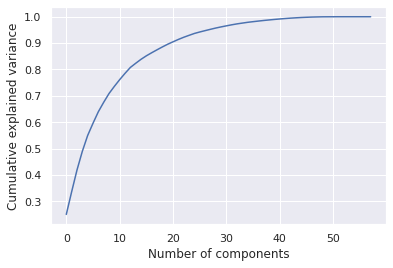

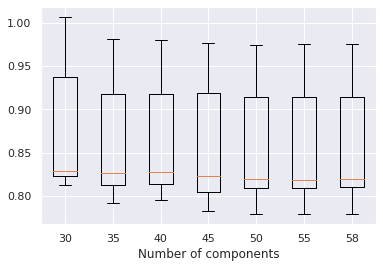

LR: -0.855204 (0.063228)
FWD: -0.848584 (0.064968)
BWD: -0.849961 (0.064930)
SW: -0.848584 (0.064968)


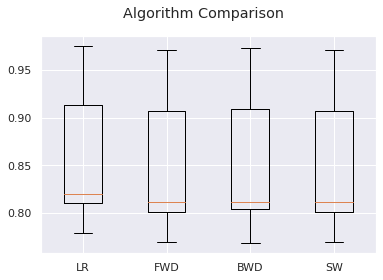

In [ ]:
from sklearn.preprocessing import FunctionTransformer
import pandas
import seaborn as sns
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from mlxtend.feature_selection import ColumnSelector
import statsmodels.api as sm
sns.set()

def backward_elimination(X, y, threshold_in = 0.05, verbose = True):
    """[This function recursively eliminates features and returns all features that are above the level of significance]

    Args:
        df ([type]): [description]
        threshold_in ([type]): [description]
        verbose (bool, optional): [description]. Defaults to True.

    Returns:
        [type]: [description]
    """    
    iterations_log = ""
    cols = list(X.columns)
    while (len(cols) > 0):
        X_1 = X[cols]
        X_1 = sm.add_constant(X_1)
        model = sm.OLS(y, X_1.astype(float)).fit()
        iterations_log += "\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n"
        p = pd.Series(model.pvalues.values[1:],index = cols)      
        best_pval = max(p)
        worst_feature = p.idxmax()
        if(best_pval > threshold_in):
            cols.remove(worst_feature)
            if verbose:
                print('Remove  {:30} with p-value {:.12}'.format(worst_feature, best_pval))
        else:
            break
    selected_features = cols
    print(f'{len(selected_features)} features selected')
    print(selected_features)
    return selected_features

def forward_elimination(X, y, threshold_in = 0.05, verbose=True):
    """[This function recursively adds features and returns all features that are above the level of significance]

    Args:
        df ([type]): [description]
        threshold_in ([type]): [description]
        verbose (bool, optional): [description]. Defaults to True.

    Returns:
        [type]: [description]
    """    
    
    initial_list = []
    selected_features = list(initial_list)
    iterations_log = ""
    while True:
        changed=False
        excluded_features = list(set(X.columns)-set(selected_features))
        new_pval = pd.Series(index=excluded_features, dtype='float64')
        for new_column in excluded_features:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[selected_features+[new_column]]))).fit()
            iterations_log += "\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n"
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            selected_features.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.12}'.format(best_feature, best_pval))
        if not changed:
            break
    print(f'{len(selected_features)} features selected')
    return selected_features
    
def stepwise_selection(data, target,SL_in=0.05,SL_out = 0.05):
    """[This function recursively adds and removes features and returns all features that are above the level of significance]

    Args:
        df ([type]): [description]
        threshold_in ([type]): [description]
        verbose (bool, optional): [description]. Defaults to True.

    Returns:
        [type]: [description]
    """    

    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            # print('Adding ', new_column)
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<SL_in):
            best_features.append(new_pval.idxmin())
            while(len(best_features)>0):
                best_features_with_constant = sm.add_constant(data[best_features])
                p_values = sm.OLS(target, best_features_with_constant).fit().pvalues[1:]
                max_p_value = p_values.max()
                if(max_p_value >= SL_out):
                    excluded_feature = p_values.idxmax()
                    # print('Removing ', excluded_feature)
                    best_features.remove(excluded_feature)
                else:
                    break 
        else:
            break
    return best_features


# Read data
df = pd.read_csv('./drive/MyDrive/Data/engineered_us.csv')
X_train, X_test, y_train, y_test, std_x, std_y = get_training_data(GW = 1, scale = True)
fwd_feat = forward_elimination(X_train, y_train)
bwd_feat = backward_elimination(X_train, y_train)
step_feat = stepwise_selection(X_train, y_train)
get_fwd_data = FunctionTransformer(lambda x: x[fwd_feat], validate=False)
get_bwd_data = FunctionTransformer(lambda x: x[bwd_feat], validate=False)
get_step_data = FunctionTransformer(lambda x: x[step_feat], validate=False)

# See if PCA can be beneficial
models = []
results = []
names = []
scoring = 'neg_mean_squared_error'
for comp in [ 30,35,40, 45, 50,55, 58]:
  models.append((f'{comp}', Pipeline([('pca', PCA(n_components=comp)), ('LR', LinearRegression())])))
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');
for name, model in models:
	kfold = model_selection.KFold(n_splits=10)
	cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	results.append(-1*cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
 
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.xlabel('Number of components')
plt.show()


# Prepare
models = []
models.append(('LR', LinearRegression()))
models.append(('FWD', Pipeline([
    ('selector', get_fwd_data),
    ('LR', LinearRegression())])))
models.append(('BWD', Pipeline([
    ('selector', get_bwd_data),
    ('LR', LinearRegression())])))
models.append(('SW', Pipeline([
    ('selector', get_step_data),
    ('LR', LinearRegression())])))


# for comp in [90,100]:
#   models.append((f'PCA {comp}', Pipeline([('pca', PCA(n_components=comp)), ('LR', LinearRegression())])))

# evaluate each model in turn
results = []
names = []
scoring = 'neg_mean_squared_error'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10)
	cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	results.append(-1*cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

[array([0.82393619, 0.91940454, 0.77871402, 0.79658052, 0.81610298,
        0.89998901, 0.80984978, 0.81443306, 0.97534303, 0.91768264]),
 array([0.81647172, 0.90980625, 0.76956498, 0.79267298, 0.80501263,
        0.89908551, 0.80003797, 0.80665402, 0.97123855, 0.9152962 ]),
 array([0.81290089, 0.91324746, 0.76822428, 0.7991277 , 0.8103803 ,
        0.8970987 , 0.80355088, 0.80529509, 0.97276708, 0.91702032]),
 array([0.81647172, 0.90980625, 0.76956498, 0.79267298, 0.80501263,
        0.89908551, 0.80003797, 0.80665402, 0.97123855, 0.9152962 ])]

Keras Regressor

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Dense, Dropout, Activation
from keras.models import Sequential


def create_model(neurons = 512, dropout_rate = 0, activation = 'relu', init_mode = 'he_uniform', optimizer = 'SGD', weight_decay = 0.01, hidden_layers = 2):
    model = Sequential()
    if hidden_layers == 0:
        pass
    else:
        for i in range(hidden_layers):
            model.add(Dense(neurons, kernel_initializer=init_mode,  kernel_regularizer=l2(weight_decay), activation=activation))
            model.add(Dropout(dropout_rate))

    model.add(Dense(1, kernel_initializer=init_mode, activation='linear'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])
    return model

keras_model = KerasRegressor(build_fn=create_model, verbose=2)

batch_size = [32] 
epochs = [1] 
neurons = [32] 
dropout_rate= [0.0]
hidden_layers = [2] 
weight_decay = [0.01]
activation = ['relu']
init_mode = ['he_uniform']
optimizer = ['SGD']

param_grid = dict(batch_size=batch_size,
    epochs=epochs,
    hidden_layers=hidden_layers,
    neurons=neurons,
     dropout_rate=dropout_rate,
     activation=activation,
     init_mode=init_mode, 
     optimizer=optimizer)

stopper = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=5)
fit_params = dict(callbacks=[stopper])
grid = GridSearchCV(model, param_grid, n_jobs= 8, cv = 4,verbose = 10).fit(X_train, y_train, **fit_params)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    2.7s remaining:    2.7s
[Parallel(n_jobs=8)]: Done   4 out of   4 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   4 | elapsed:    2.8s finished


334/334 - 1s - loss: 0.2041 - mse: 0.2041
